In [1]:
import torchvision
import torch
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

In [2]:
transformations = transforms.Compose([
    transforms.CenterCrop(255),
    transforms.Resize(100),
    transforms.ToTensor()])

voc_data = torchvision.datasets.Cityscapes('data', split="train", mode="fine", target_type="semantic",
                                           transform=transformations, target_transform=transformations)
data_loader = torch.utils.data.DataLoader(voc_data,batch_size=32,shuffle=True)

In [3]:
one, two = voc_data.__getitem__(15)

In [4]:
def get_features(image, seg):
    
    image = np.transpose(image,(1,2,0))
    nrows, ncols, nchan = image.shape
    features = np.zeros((nrows*ncols, nchan+2))
    y = np.zeros((nrows*ncols))
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            colors = image[i, j, :]
            features[count, :] = [colors[0], colors[1], colors[2], i/100, j/100]
            #features[count, :] = [i, j]
            y[count] = seg[0, i, j]
            count = count + 1
    return features/np.max(features), y

In [5]:
def get_representative(features, y):
    y0 = y[y==np.min(y)]
    y1 = y[y ==np.max(y)]
    samp0_i = np.random.choice(range(len(y0)))
    samp1_i = np.random.choice(range(len(y1)))
    feat0 = features[samp0_i, :]
    feat1 = features[samp1_i, :]
    y0 = y0[samp0_i]
    y1 = y1[samp1_i]
    return feat0, y0, feat1, y1

In [ ]:
from sklearn.model_selection import train_test_split

In [48]:
n = 1
total = 0.0
for i in range(100):
    one, two = voc_data.__getitem__(i)
    X, y = get_features(one.numpy(), two.numpy())
    y = np.round((y/np.min(y)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n)

    kernel = gp.kernels.RBF(input_dim=5, variance=torch.tensor(1.),
                            lengthscale=torch.tensor(10.))
    gpr = gp.models.GPRegression(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float(), kernel, noise=torch.tensor(1.))

    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 10
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
    mean, cov = gpr(torch.from_numpy(X).float())
    loss = np.mean((mean.detach().numpy()-y)**2)
    total += loss
print(total / 10)

0
1
2
3
4
5
6
7
8
9
4.549055295695519


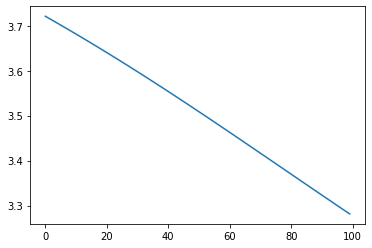

In [35]:
plt.plot(range(num_steps), losses)

In [36]:
mean, cov = gpr(torch.from_numpy(X).float())

In [37]:
y_hat = mean.detach().numpy()

(-0.5, 99.5, 99.5, -0.5)

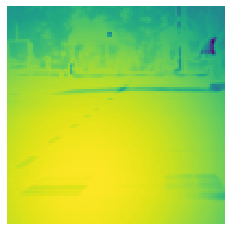

In [38]:
plt.imshow(y_hat.reshape(100, 100))
plt.axis("off")

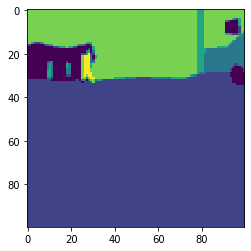

In [23]:
plt.imshow(y.reshape(100, 100))

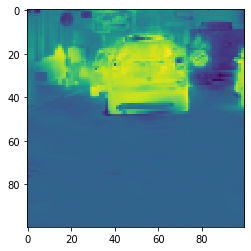

In [37]:
plt.imshow(y_1000.reshape(100, 100))

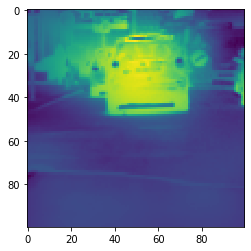

In [38]:
plt.imshow(y_100.reshape(100, 100))

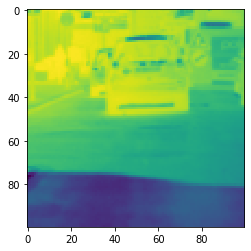

In [40]:
plt.imshow(y_10.reshape(100, 100))

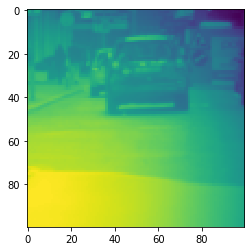

In [63]:
plt.imshow(y_1.reshape(100, 100))

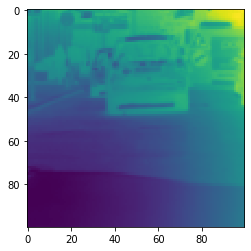

In [70]:
plt.imshow(cov.detach().reshape(100, 100))